In [1]:
## Python Script for the Final Project, Stats 506 F20
##
## For adults who weigh less than they were 10 years ago, what nutrient
## intake and demographic factors are important for them now?
##
## Data source: National Health and Nutrition Examination Survey (NHANES)
## https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016
## https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018 
##
## Author: Yingyi Yang, yyingyi@umich.edu
## Updated: December 15, 2020

#! Limit lines to 79 characters with rare exceptions. 
# 79: -------------------------------------------------------------------------

In [168]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

### 1. Data preprocessing 

In [190]:
def prep_data(year):
    """
    Function to read nhanes data based on year codes and merge them into one 
    dataframe.
    Input: year - list of alphabet representing year of concern
    Output: a dataframe containing required covariates and response variable
    """
    
    base = 'data/'
    
    files = []
    
    var = [
        ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'DMDEDUC2', 'INDHHIN2'],
        ['SEQN', 'DR1DRSTZ', 'DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR', 
         'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL'],
        ['SEQN', 'WHD020', 'WHD110']
    ]
    
    out = pd.DataFrame()
    for code in year:
        names = [x+'_'+code+'.XPT' for x in ['DEMO', 'DR1TOT', 'WHQ']]

        da = []
        for idf, fn in enumerate(names):
            df = pd.read_sas(os.path.join(base, fn))
            df = df.loc[:, var[idf]]
            da.append(df)
            
        dx = pd.merge(da[0], da[1], left_on='SEQN', right_on='SEQN')
        dx = pd.merge(dx, da[2], left_on='SEQN', right_on='SEQN')

        # encode sex groups
        dx['Female'] = (dx.RIAGENDR == 2).astype(np.int)   
        
        dx.dropna(inplace = True)
        out = out.append(dx)
    
    out['Wloss'] = (out['WHD020'] < out['WHD110']-5.0).astype(np.int)
    
    # remove values that are not reliable
    out = out[(out['DR1DRSTZ'] == 1) & (out['DMDEDUC2'] <= 5) &
             (out['INDHHIN2'] <= 15)]
    out.drop(['SEQN', 'RIAGENDR', 'WHD020', 'WHD110', 'DR1DRSTZ'], 
             axis=1, inplace=True)

    out.rename(columns={'RIAGENDR': 'Gender',
                        'RIDAGEYR': 'Age',
                        'DMDEDUC2': 'Education',
                        'INDHHIN2': 'Household income',
                        'DR1TKCAL': 'Energy',
                        'DR1TPROT': 'Protein', 
                        'DR1TCARB': 'Carbohydrate',
                        'DR1TSUGR': 'Sugars',
                        'DR1TFIBE': 'Fiber',
                        'DR1TTFAT': 'Fat',
                        'DR1TSFAT': 'Saturated fatty acids',
                        'DR1TMFAT': 'Monounsaturated fatty acids',
                        'DR1TPFAT': 'Polyunsaturated fatty acids',
                        'DR1TCHOL': 'Cholesterol'}, inplace=True)
    
    return out    

In [191]:
df = prep_data(['I','J'])
df.shape

(6711, 15)

In [192]:
df.head()

,Age,Education,Household income,Energy,Protein,Carbohydrate,Sugars,Fiber,Fat,Saturated fatty acids,Monounsaturated fatty acids,Polyunsaturated fatty acids,Cholesterol,Female,Wloss
0,62.0,5.0,10.0,1781.0,76.03,193.29,42.31,23.6,79.24,23.430,31.897,18.528,138.0,0,1
1,53.0,3.0,4.0,2964.0,62.36,356.85,180.84,7.3,77.91,25.722,19.098,19.216,407.0,0,0
2,78.0,3.0,5.0,2482.0,116.50,304.53,62.87,35.1,91.97,23.122,28.666,32.561,506.0,0,1
3,56.0,5.0,10.0,1340.0,70.38,157.99,54.77,14.0,49.23,17.593,18.327,9.588,138.0,1,0
4,42.0,4.0,7.0,604.0,19.30,90.30,71.84,2.0,19.63,4.581,8.504,3.889,96.0,1,0


### 2. Feature selection 

In [79]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
from sklearn.feature_selection import RFE
import seaborn as sns

In [232]:
def featureSelection(data, n, method = 'Model_LR'):
    """
    Function to fit model and generate features based on the input method.
    Inputs: data - a dataframe containing covariates and response variable
            n - an integer representing top n important features
            method - a string containing feature selection method 
            (Model: model-based, RFE: recursive feature elimination) and model 
            (LR: logistic regression, tree: decision tree)
    Output: a figure or dataframe representing selected features
    """
 
    X = data.iloc[:,:-1]
    y = data.iloc[:,-1]
    
    # standardize columns of X
    scaler = preprocessing.StandardScaler()
    scaled_X = scaler.fit_transform(X)
    X = pd.DataFrame(scaled_X, columns=X.columns)
    
    if method == 'Model_LR':
        LR = sm.Logit(y.values.reshape(-1,1), X).fit()
        
        # select significant variables
        idx = (LR.pvalues < 0.1)
        coeffs = pd.DataFrame({'Feature coeffs':LR.params[idx]})
        
        coeffs = coeffs.iloc[(-coeffs['Feature coeffs'].abs()).argsort()
                   ].reset_index(level=0).rename(
                     columns={'index':'Feature name'}).iloc[:n,:]
        
        # output results
        coeffs.to_csv('results/Model_LR.csv')

        plt.figure(figsize=(6,6))
        plt.title("Coefficients")
        sns.barplot(x="Feature coeffs", y="Feature name", 
                    data=coeffs, palette='Blues')  
    
    if method == 'Model_tree':
        tree = DecisionTreeClassifier()
        tree.fit(X, y)      
        importances = tree.feature_importances_
        imp_df = pd.DataFrame({'Feature name':X.columns.values, 
                               'Feature importance':importances}
                             ).sort_values('Feature importance', 
                                           ascending=False).iloc[:n,:]
        
        # output results
        imp_df.to_csv('results/Model_tree.csv')

        plt.figure(figsize=(6,6))
        plt.title("Feature Importance")
        sns.barplot(x="Feature importance", y="Feature name", 
                    data=imp_df, palette='Blues')
        
    if method == 'RFE_LR':
        LR = LogisticRegression()
        trans = RFE(LR, n_features_to_select=n)
        X_trans = trans.fit_transform(X, y)
        features = X.columns.values[trans.get_support()]
        imp_df = pd.DataFrame(features)
        
        # output results
        imp_df.to_csv('results/RFE_LR.csv')
   
        for i in range(X.shape[1]):
            print('Variable: %s, Selected %s, Rank: %.3f' % 
                  (X.columns.values[i], trans.support_[i], trans.ranking_[i]))
        
    if method == 'RFE_tree':
        tree = DecisionTreeClassifier()
        trans = RFE(tree, n_features_to_select=n)
        X_trans = trans.fit_transform(X, y)
        features = X.columns.values[trans.get_support()]
        imp_df = pd.DataFrame(features)
        
        # output results
        imp_df.to_csv('results/RFE_tree.csv')
        
        for i in range(X.shape[1]):
            print('Variable: %s, Selected %s, Rank: %.3f' % 
                  (X.columns.values[i], trans.support_[i], trans.ranking_[i]))       

### 3. Results visualization 

Optimization terminated successfully.
         Current function value: 0.676256
         Iterations 4


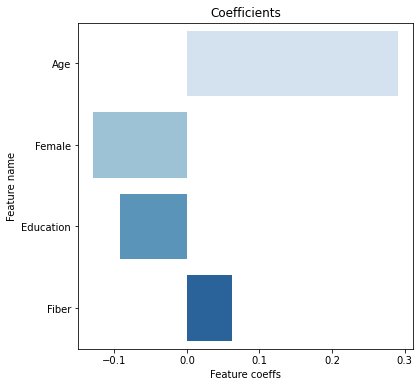

In [233]:
featureSelection(df, 5, 'Model_LR')

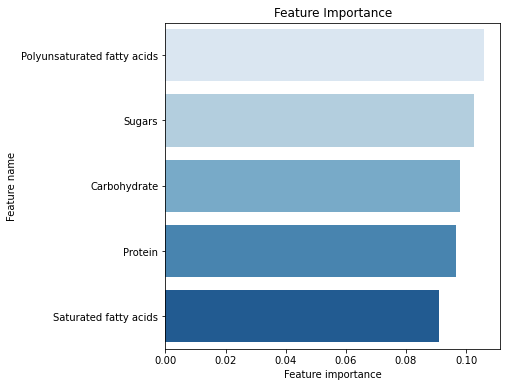

In [234]:
featureSelection(df, 5, 'Model_tree')

In [235]:
featureSelection(df, 5, 'RFE_LR')

Variable: Age, Selected True, Rank: 1.000
Variable: Education, Selected False, Rank: 3.000
Variable: Household income, Selected False, Rank: 6.000
Variable: Energy, Selected True, Rank: 1.000
Variable: Protein, Selected False, Rank: 7.000
Variable: Carbohydrate, Selected False, Rank: 10.000
Variable: Sugars, Selected False, Rank: 8.000
Variable: Fiber, Selected False, Rank: 5.000
Variable: Fat, Selected True, Rank: 1.000
Variable: Saturated fatty acids, Selected False, Rank: 4.000
Variable: Monounsaturated fatty acids, Selected True, Rank: 1.000
Variable: Polyunsaturated fatty acids, Selected False, Rank: 2.000
Variable: Cholesterol, Selected False, Rank: 9.000
Variable: Female, Selected True, Rank: 1.000


In [236]:
featureSelection(df, 5, 'RFE_tree')

Variable: Age, Selected False, Rank: 6.000
Variable: Education, Selected False, Rank: 9.000
Variable: Household income, Selected False, Rank: 7.000
Variable: Energy, Selected True, Rank: 1.000
Variable: Protein, Selected True, Rank: 1.000
Variable: Carbohydrate, Selected False, Rank: 3.000
Variable: Sugars, Selected False, Rank: 2.000
Variable: Fiber, Selected True, Rank: 1.000
Variable: Fat, Selected False, Rank: 8.000
Variable: Saturated fatty acids, Selected True, Rank: 1.000
Variable: Monounsaturated fatty acids, Selected True, Rank: 1.000
Variable: Polyunsaturated fatty acids, Selected False, Rank: 5.000
Variable: Cholesterol, Selected False, Rank: 4.000
Variable: Female, Selected False, Rank: 10.000
